In [4]:
'''Parsing semi-structured MS WORD files using gpt-4-o'''
from tqdm import tqdm
import os
import requests
import json
import pandas as pd
import docx

def normalize_json_output(json_output):
    """
    Normalize the keys and convert list values to comma-separated strings.
    """
    normalized_output = {}
    for key, value in json_output.items():
        normalized_key = key.lower().replace(" ", "_")
        if isinstance(value, list):
            normalized_output[normalized_key] = ', '.join(value)
        else:
            normalized_output[normalized_key] = value
    return normalized_output


def extract_text_from_docx(docx_path: str):
    """
    Extract text content from a Word (.docx) file, including text from paragraphs, tables, headers, and footers.
    """
    doc = docx.Document(docx_path)
    full_text = []

    # Extract text from paragraphs
    for para in doc.paragraphs:
        full_text.append(para.text)

    # Extract text from tables
    for table in doc.tables:
        for row in table.rows:
            for cell in row.cells:
                full_text.append(cell.text)

    # Extract text from headers and footers (if needed)
    for section in doc.sections:
        header = section.header
        footer = section.footer
        for para in header.paragraphs:
            full_text.append(para.text)
        for para in footer.paragraphs:
            full_text.append(para.text)

    return '\n'.join(full_text).strip()

def process_files(directory_path: str, api_key: str, system_message: str):
    """
    Process all .docx files in the given directory and its subdirectories,
    send their content to the LLM, and store the JSON responses.
    """
    json_outputs = []
    docx_files = []

    # Walk through the directory and its subdirectories to find .docx files
    for root, dirs, files in os.walk(directory_path):
        for file in files:
            if file.endswith(".docx"):
                docx_files.append(os.path.join(root, file))

    if not docx_files:
        print("No .docx files found in the specified directory or sub-directories.")
        return json_outputs

    # Iterate through all .docx files in the directory with a progress bar
    for file_path in tqdm(docx_files, desc="Processing files...", unit="file"):
        filename = os.path.basename(file_path)
        extracted_text = extract_text_from_docx(file_path)
        # Prepare the user message with the extracted text
        input_message = extracted_text

        # Prepare the API request payload
        headers = {
            "Content-Type": "application/json",
            "Authorization": f"Bearer {api_key}"
        }
        payload = {
            "model": "gpt-4o-mini",
            "messages": [
                {"role": "system", "content": system_message},
                {"role": "user", "content": input_message}
            ],
            "max_tokens": 2000,
            "temperature": 0.2
        }

        # Send the request to the LLM API
        response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)

        # Extract the JSON response
        json_response = response.json()
        content = json_response['choices'][0]['message']['content'].strip("```json\n").strip("```")
        parsed_json = json.loads(content)

        # Normalize the parsed JSON output
        normalized_json = normalize_json_output(parsed_json)

        # Append the normalized JSON output to the list
        json_outputs.append(normalized_json)

    return json_outputs

def save_json_to_excel(json_outputs, output_file_path: str):
    """
    Save the list of JSON objects to an Excel file with a SNO. column.
    """
    # Convert the list of JSON objects to a DataFrame
    df = pd.DataFrame(json_outputs)

    # Add a Serial Number (SNO.) column
    df.insert(0, 'SNO.', range(1, len(df) + 1))

    # Ensure all columns are consistent and save the DataFrame to an Excel file
    df.to_excel(output_file_path, index=False)

# Directory containing files
directory_path = 'Documents_semi_structured'

# API key for GPT-4-mini
api_key = 'YOUR_OPENAI_API_KEY'

# System message with extraction instructions
system_message = """
You are an expert in analyzing and extracting information from the feedback forms written by AI experts after AI advisory sessions with companies.  
Please carefully read the provided feedback form and extract the following 15 key information. Make sure that the key names are exactly the same as 
given below. Do not create any additional key names other than these 15. 
Key names and their descriptions:
1. Company name: name of the company seeking AI advisory
2. Country: Company's country [output 'N/A' if not available]
3. Consultation Date [output 'N/A' if not available]
4. Experts: persons providing AI consultancy [output 'N/A' if not available]
5. Consultation type: Regular or pop-up [output 'N/A' if not available]
6. Area/domain: refers to the field of the company’s operations such as healthcare, industrial manufacturing, business development, education, etc. 
7. Current Solution: description of the current solution offered by the company. The company could be currently in ideation phase. Some examples of ‘Current Solution’ field include i) Recommendation system for cars, houses, and other items, ii) Professional guidance system, iii) AI-based matchmaking service for educational peer-to-peer support. [Be very specific and concise]
8. AI field: refer to the AI's sub-field in use or required such as image processing, large language models, computer vision, NLP, predictive modeling, NLP, OCR, speech-to-text, etc. [This field is not explicitly available in the document. Extract it by the semantic understanding of the overall document.]
9. AI maturity level: low, moderate, high [output 'N/A' if not available].
10. Company type: ‘startup’ or ‘established company’
11. Aim: What AI task the company is looking for. Examples of ‘Aim’ field include i) Enhance AI-driven systems for diagnosing heart diseases, ii) to automate identification of key variable combinations in customer surveys, iii) to develop AI-based system for automatic quotation generation from engineering drawings, iv) to building and managing enterprise-grade LLM applications. [Be very specific and concise]
12. Identified target market: refer to the targeted customers such as healthcare professionals, construction firms, hospitality, educational institutions, etc. 
13. Data Requirement Assessment: what type of data is required for the intended AI integration? For example, Transcripts of therapy sessions, patient data, textual data, image data, videos, etc. 
14. FAIR Services Sought: What services are expected from FAIR? For instance, technical advice, proof of concept. 
15. Recommendations: A brief summary of the recommendations in the form of key words or phrase list. For instance: i) Focus on data balance, monitor for bias, prioritize transparency, ii) Explore machine learning algorithms, implement decision trees, gradient boosting. [Be very specific and concise] 
Guidelines:
- Very important: do not make up anything. If the information of a required field is not available, output ‘N/A’ for it.
- Output in JSON format. The JSON should contain the above 15 keys.
"""

# Process files and get the JSON outputs
json_outputs = process_files(directory_path, api_key, system_message)

if json_outputs:

    # Save the JSON outputs to an Excel file
    output_file_path = 'processed-gpt-o-mini.xlsx'
    save_json_to_excel(json_outputs, output_file_path)
    print(f"Processed data has been saved to {output_file_path}")
else:
    print("No .docx file found.")


Processing files...: 100%|█████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.40s/file]

Processed data has been saved to C:/Users/h02317/Downloads/processed.xlsx


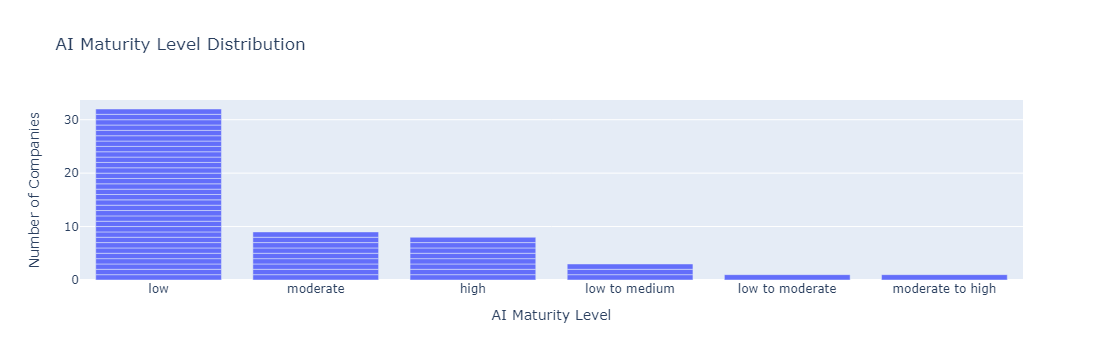

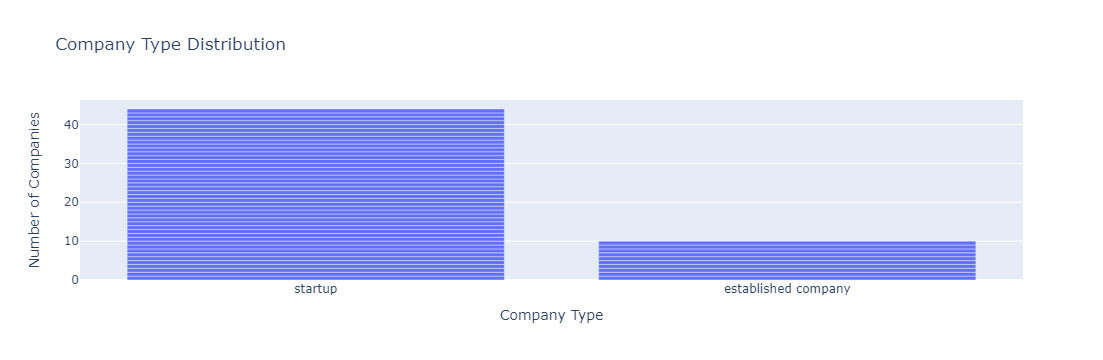

In [194]:
'''Analysis of the structured data '''

import pandas as pd
import plotly.express as px

# Load the structured .xlsx file generated in the pervious step
file_path = 'processed-gpt-o-mini.xlsx' 
data = pd.read_excel(file_path)

# Convert fields to lowercase to make them consistent
data['ai_maturity_level'] = data['ai_maturity_level'].str.lower()
data['company_type'] = data['company_type'].str.lower()

# Plot for AI Maturity Level
fig_ai_maturity = px.bar(data, 
                         x='ai_maturity_level', 
                         title="AI Maturity Level Distribution",
                         labels={'ai_maturity_level': 'AI Maturity Level', 'count': 'Number of Companies'})

# Update layout for AI Maturity Level plot
fig_ai_maturity.update_layout(
    xaxis_title="AI Maturity Level",
    yaxis_title="Number of Companies",
    xaxis={'categoryorder':'total descending'},  # Order bars by descending number of companies
    yaxis=dict(type='linear'),
    showlegend=False
)

# Display the AI Maturity Level figure
fig_ai_maturity.show()

# Plot for Company Type
fig_company_type = px.bar(data, 
                          x='company_type', 
                          title="Company Type Distribution",
                          labels={'company_type': 'Company Type', 'count': 'Number of Companies'})

# Update layout for Company Type plot
fig_company_type.update_layout(
    xaxis_title="Company Type",
    yaxis_title="Number of Companies",
    xaxis={'categoryorder':'total descending'},  # Order bars by descending number of companies
    yaxis=dict(type='linear'),
    showlegend=False
)

# Display the Company Type figure
fig_company_type.show()


Loading embeddings from all_domains_embeddings_2.pkl...
Finding optimal number of clusters
Optimal number of clusters: 15


C:\Users\h02317\RAG\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

C:\Users\h02317\RAG\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



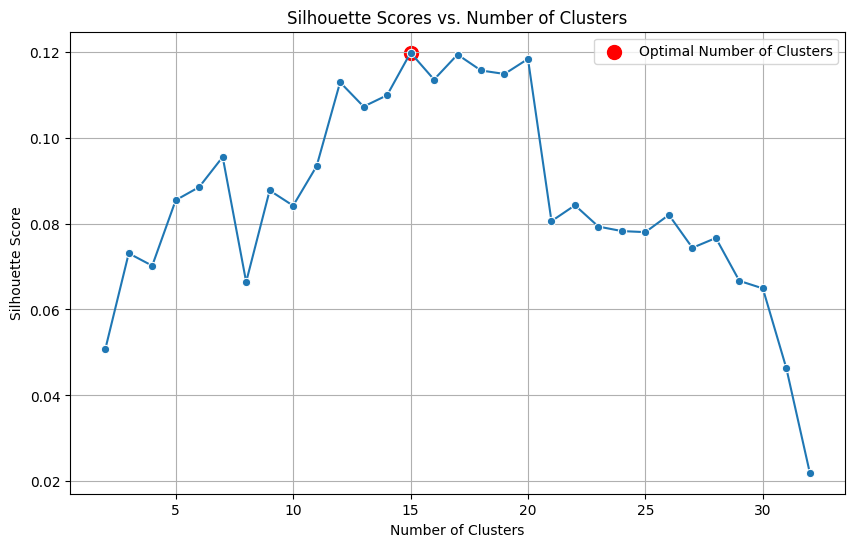


Deduplicated Clusters:
Cluster 3:
  - healthcare
  - hospitality
Cluster 2:
  - business development
  - consulting
Cluster 8:
  - logistics optimization
  - logistics
Cluster 11:
  - environmental sustainability
  - health and climate action
Cluster 1:
  - entertainment
Cluster 4:
  - industrial manufacturing
  - manufacturing
Cluster 6:
  - ai technology services
  - defense technology
Cluster 10:
  - health technology, digital therapeutics
  - functional medicine
  - digital health marketplace
Cluster 0:
  - construction and real estate measurement
  - construction and architecture
  - architecture, construction
  - construction
  - construction, renovation, repair, real estate
  - construction industry and related sectors, engineering, architecture,  product design
  - construction and property industry
Cluster 9:
  - dental education and patient communication
Cluster 12:
  - ict services
  - research and innovation support
  - communication services for the elderly and disabled
C

In [193]:
'''Finding the major topics (clusters) in a given field using k-means clustering'''

import numpy as np
import pandas as pd
import umap
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from openai import OpenAI
import pickle
import os
import seaborn as sns

def fetch_embeddings(texts, filename):
    # Check if the embeddings file already exists; otherwise, create a new embedding file and save it for later use
    if os.path.exists(filename):
        print(f"Loading embeddings from {filename}...")
        with open(filename, 'rb') as f:
            embeddings = pickle.load(f)
    else: 
        print("Computing embeddings...")
        embeddings = []
        for text in texts:
            embedding = client.embeddings.create(input=[text], model="text-embedding-3-small").data[0].embedding
            embeddings.append(embedding)
        embeddings = np.array(embeddings)
        # Save the embeddings 
        print(f"Saving embeddings to {filename}...")
        with open(filename, 'wb') as f:
            pickle.dump(embeddings, f)
    return embeddings

# Function to plot silhouette scores
def plot_silhouette_scores(K_range, silhouette_scores, optimal_clusters):
    plt.figure(figsize=(10, 6))
    # Plot silhouette scores as a line plot
    sns.lineplot(x=K_range, y=silhouette_scores, marker="o", dashes=False)
    # Find the index of the optimal number of clusters
    optimal_index = K_range.index(optimal_clusters)
    # Highlight the optimal number of clusters with a red marker
    plt.scatter(optimal_clusters, silhouette_scores[optimal_index], color='red', s=100, label='Optimal Number of Clusters')
    # Add titles and labels
    plt.title("Silhouette Scores vs. Number of Clusters")
    plt.xlabel("Number of Clusters")
    plt.ylabel("Silhouette Score")
    plt.legend()
    plt.grid(True)
    # Save the plot as a PNG file
    plt.savefig('C:/Users/h02317/Downloads/clusters.png')
    # Display the plot
    plt.show()

# Initialize the OpenAI client
client = OpenAI(api_key="YOUR_OPENAI_API_KEY")  # Replace with your actual OpenAI API key

# Load the dataset
file_path = 'processed-gpt-o-mini.xlsx'
data = pd.read_excel(file_path)

# Extract the "area/domain" field and process the data
area_domain_data = data['area/domain'].dropna().tolist()

# Deduplicate the data while keeping track of the original indices
deduplicated_domains = []
original_to_dedup = []
for item in area_domain_data:
    item_lower = item.capitalize()#you may also test item.lower() for lower case or leave the text as it is.
    if item_lower not in deduplicated_domains:
        deduplicated_domains.append(item_lower)
    original_to_dedup.append(deduplicated_domains.index(item_lower))

# Fetch embeddings for all deduplicated domain data points
embeddings = fetch_embeddings(deduplicated_domains, filename="all_domains_embeddings_2.pkl")

# Determine the optimal number of clusters using the silhouette score
silhouette_scores = []
K_range = list(range(2, len(deduplicated_domains)))  # Testing between 2 and the number of unique domains
print('Finding optimal number of clusters')
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(embeddings)
    score = silhouette_score(embeddings, kmeans.labels_)
    silhouette_scores.append(score)

# Find the number of clusters with highest silhouette score
optimal_k = K_range[np.argmax(silhouette_scores)]
print(f'Optimal number of clusters: {optimal_k}')

# Plot the silhouette scores
plot_silhouette_scores(K_range, silhouette_scores, optimal_k)

# Perform k-means clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(embeddings)
dedup_clusters = kmeans.labels_

# Map clusters back to the original data points
original_clusters = [dedup_clusters[idx] for idx in original_to_dedup]

# Display deduplicated clusters
print("\nDeduplicated Clusters:")
dedup_clustered_data = {}
for i, label in enumerate(dedup_clusters):
    if label not in dedup_clustered_data:
        dedup_clustered_data[label] = []
    dedup_clustered_data[label].append(deduplicated_domains[i])

for cluster_id, domain_list in dedup_clustered_data.items():
    print(f"Cluster {cluster_id}:")
    for domain in domain_list:
        print(f"  - {domain}")

# Display original clusters
print("\nOriginal Clusters with Actual Number of Data Points:")
original_clustered_data = {}
for i, label in enumerate(original_clusters):
    if label not in original_clustered_data:
        original_clustered_data[label] = []
    original_clustered_data[label].append(area_domain_data[i])

for cluster_id, domain_list in original_clustered_data.items():
    print(f"Cluster {cluster_id}:")
    for domain in domain_list:
        print(f"  - {domain}")

In [195]:
'''Label each cluster through gpt-4-o-mini'''
import requests
import json
import pandas as pd

pd.set_option('display.max_colwidth', None)

# Function to label clusters using GPT-4-o-mini
def label_clusters_with_gpt(clusters, api_key):
    # Prepare the input for GPT-4
    cluster_descriptions = []
    for cluster_id, data_points in clusters.items():
        cluster_descriptions.append(f"Cluster {cluster_id}: {', '.join(data_points)}")
    # Prepare the system and input messages
    system_message = "You are a helpful assistant"
    input_message = (
        "Please label each of the following clusters with a concise, specific label based on the semantic similarity "
        "of the data points within each cluster."
        "Output in a JSON format where the keys are cluster numbers and the values are cluster labels."
        "\n\n" + "\n".join(cluster_descriptions)
    )
    
    # Set up the request payload
    headers = {
        "Content-Type": "application/json",
        "Authorization": f"Bearer {api_key}"
    }
    payload = {
        "model": "gpt-4o-mini",  # Model name
        "messages": [
            {"role": "system", "content": system_message},
            {"role": "user", "content": input_message}
        ],
        "max_tokens": 2000,
        "temperature": 0.7
    }
    
    # Send the request to the API
    response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)
    
    # Extract and parse the response
    if response.status_code == 200:
        response_data = response.json()
        response_text = response_data['choices'][0]['message']['content'].strip()
        try:
            # Ensure that the JSON is correctly formatted
            response_text = response_text.replace("```json", "").replace("```", "").strip()
            cluster_labels = json.loads(response_text)
        except json.JSONDecodeError as e:
            print("Failed to parse JSON:", e)
            cluster_labels = {}
        
        return cluster_labels
    else:
        print(f"Request failed with status code {response.status_code}")
        print("Response Body:", response.text)
        return None

# Function to convert the JSON labeled clusters into a DataFrame
def clusters_to_dataframe(cluster_labels, clusters, original_clustered_data):
    data = {"Cluster Number": [], "Label": [], "Unique Data Points": [], "Original Data Points": []}
    
    # Iterate through the cluster labels
    for cluster_num, label in cluster_labels.items():
        cluster_num = int(cluster_num)  # Convert cluster number to integer
        data["Cluster Number"].append(cluster_num)
        data["Label"].append(label)
        data["Unique Data Points"].append(repr(clusters[cluster_num]))  # Use repr to retain the original list format
        data["Original Data Points"].append(len(original_clustered_data[cluster_num]))  # Count original data points
    
    # Convert to DataFrame and sort by "Cluster Number"
    df = pd.DataFrame(data)
    df = df.sort_values(by='Cluster Number').reset_index(drop=True)
    return df

api_key = 'YOUR_OPENAI_API'  # Replace with your actual OpenAI API key
# Use dedup_clustered_data and original_clustered_data from previous code
labeled_clusters = label_clusters_with_gpt(dedup_clustered_data, api_key)
df_labeled_clusters = clusters_to_dataframe(labeled_clusters, dedup_clustered_data, original_clustered_data)
df_labeled_clusters


,Cluster Number,Label,Unique Data Points,Original Data Points
0,0,Construction and Real Estate,"['construction and real estate measurement', 'construction and architecture', 'architecture, construction', 'construction', 'construction, renovation, repair, real estate', 'construction industry and related sectors, engineering, architecture, product design', 'construction and property industry']",7
1,1,Entertainment Industry,['entertainment'],1
2,2,Business Development and Consulting,"['business development', 'consulting']",3
3,3,Healthcare and Hospitality,"['healthcare', 'hospitality']",17
4,4,Industrial Manufacturing,"['industrial manufacturing', 'manufacturing']",2
5,5,Early Childhood and Music Education,"['early childhood education', 'education', 'music education']",8
6,6,AI and Defense Technology,"['ai technology services', 'defense technology']",2
7,7,Matchmaking Platforms,['matchmaking platform'],1
8,8,Logistics and Optimization,"['logistics optimization', 'logistics']",2
9,9,Dental Education and Communication,['dental education and patient communication'],1


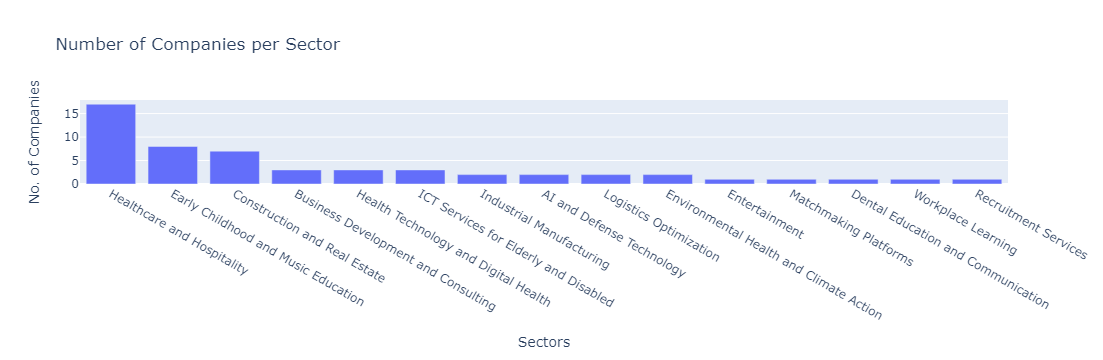

In [190]:
'''draw visualization'''
import plotly.express as px

# Use the "Original Data Points" column for the number of companies
df_labeled_clusters['No. of companies'] = df_labeled_clusters['Original Data Points']

# Create the Plotly bar chart
fig = px.bar(df_labeled_clusters, 
             x='Label', 
             y='No. of companies', 
             title="Number of Companies per Sector", 
             labels={'Label': 'Sectors', 'No. of companies': 'No. of Companies'})

# Update layout for better visibility
fig.update_layout(
    xaxis_title="Sectors",
    yaxis_title="No. of Companies",
    xaxis={'categoryorder':'total descending'},  # Order bars by descending number of companies
    yaxis=dict(type='linear'),
    showlegend=False
)

# Display the figure
fig.show()
